# Visualizing userscripts use in MusicBrainz

In this notebook I'm interested in looking at how much MusicBrainz editors use advanced tools to modify the MusicBrainz website interface and help them edit faster. In order to do this I used a snapshot of the MusicBrainz (editing history included) from early March 2017.

Disclaimer: I am myself a developper and heavy user of userscripts, so this notebook should also help learn about the community that uses my scripts.

## About userscripts

Userscripts (using TamperMonkey, GreaseMonnkey...) are code that can be applied on certain webpages to modify the way it is displayed or behaves. Advanced MusicBrainz editors often use these scripts to simplify repetitive operations (similarly to batch operations the relationship editor allows) and replace actions that normally require dozen of clicks in the satandard interface. Userscripts are usually not recommended for beginner editors since they can modify the standard behavior or make pages more complex (adding boxes for new actions).

In [1]:
%matplotlib inline
import psycopg2
import pandas
import sqlalchemy
# define DB
PGHOST = "192.168.11.2"
PGDATABASE = "musicbrainz_db"
PGUSER = "musicbrainz"
PGPASSWORD = "musicbrainz"

engine = sqlalchemy.create_engine(
   'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}/{PGDATABASE}'.format(**locals()),
    isolation_level='READ UNCOMMITTED')

# helper function
def sql(query, **kwargs):
    params = globals().copy()
    params.update(kwargs)
    return pandas.read_sql(query, engine, params=params)

## Looking for edits using a certain userscript

Let's take the example of the "MASS MERGE RECORDINGS" script written by jesus2099. It allows to merge easily a set of recordings, e.g. recordings used on two editions of the same album that were added indenpendently in MusicBrainz.

The simplest way to find edits using this userscript is to look for the automatic edit note left by this script:

In [2]:
with psycopg2.connect(host=PGHOST, database=PGDATABASE, 
                      user=PGUSER, password=PGPASSWORD) as cnx:
    crs = cnx.cursor()
    crs.execute("""
SELECT COUNT(*) 
  FROM edit_note 
 WHERE text ILIKE '%MASS MERGE RECORDINGS%';
""")
pprint(crs.fetchall())

[(327676,)]


So more than 300.000 edits used this script (note that since the edit note is written for each recording used in the mass merge, the actual number of calls to this script is probably at least twice lower – still! that's impressive).

## Looking for editors using a certain userscript

So what's next? The edit_note table also gives us the name of the editor in each case, so we should be able to regroup edits by editor:

In [3]:
df = sql("""
SELECT editor.name AS editor,
       1 AS cnt,          -- added to make easier to compute partial counts later
       post_time AS date
  FROM editor
  JOIN edit_note ON editor = editor.id
 WHERE edit_note.text ILIKE '%%MASS MERGE RECORDINGS%%';
""")
df.date = df.date.apply(lambda d: d.normalize()) # simplify dates, remove the hours
df.head()

,editor,cnt,date
0,jesus2099,1,2011-12-30 00:00:00+00:00
1,jesus2099,1,2011-12-30 00:00:00+00:00
2,jesus2099,1,2011-12-30 00:00:00+00:00
3,jesus2099,1,2011-12-30 00:00:00+00:00
4,jesus2099,1,2011-12-30 00:00:00+00:00


We can regroup the edits by editor to have partial counts:

In [4]:
df.groupby('editor').sum().size

154

So 154 distinct editors used this script. Let's find the most prolific editors:

In [5]:
editor_count = df.groupby('editor').sum().sort_values(by='cnt', ascending=False)
editor_count.head(10)

,cnt
editor,
pankkake,48962
pomes27,46598
jesus2099,38721
bflaminio,27053
monxton,20633
loujin,14857
ProfChris,11233
ListMyCDs.com,10985
ebz777,8992


So jesus2099 is only the third most frequent user of his own script. What if we plot the distribution of the 50 most frequent users?

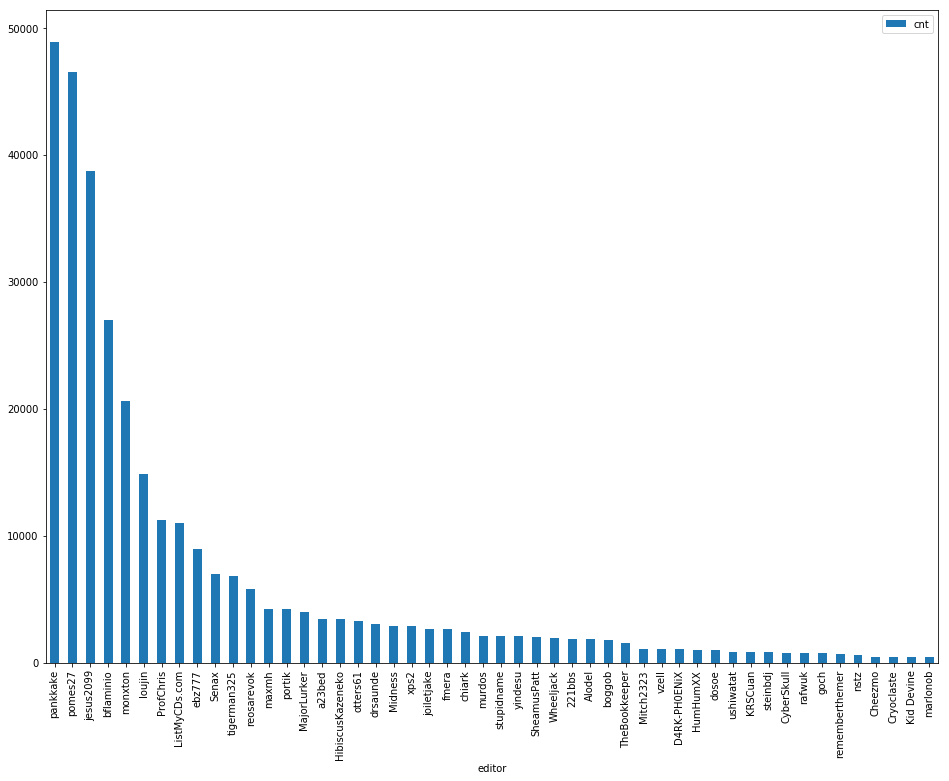

In [6]:
editor_count.head(50).plot(kind='bar', rot=90, figsize=(16,12), fontsize=10)

As we could expect, a few users used the script more than 10.000 times, and we have a *long tail*

## Using plotly

Up to now we used the matplotlib library, which is great for static graphics. One other possibility is to use the [plot.ly](https://plot.ly/ipython-notebooks/) library for interactive graphs, using its IPython interface.

In [7]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [8]:
iplot([go.Bar(x=editor_count.head(50).index, y=editor_count.head(50).cnt)])

## Displaying a userscript use with time

In [9]:
date_count = df.groupby('date').sum()
date_count.head(10)

,cnt
date,
2011-12-13 00:00:00+00:00,6
2011-12-15 00:00:00+00:00,13
2011-12-30 00:00:00+00:00,11
2012-01-03 00:00:00+00:00,13
2012-01-16 00:00:00+00:00,16
2012-01-17 00:00:00+00:00,13
2012-01-24 00:00:00+00:00,13
2012-01-27 00:00:00+00:00,42
2012-07-03 00:00:00+00:00,3


In [10]:
iplot([go.Scatter(x=date_count.index, y=date_count.cnt)])

This is the distribution of edits using the userscript by day. Of course fluctuations are quite important... it might be cleaner to display the number of edits by week. Fortunately pandas allows to resample data easily:

In [11]:
dc = date_count.asfreq('W').fillna(0)
iplot([go.Scatter(x=dc.index, y=dc.cnt)])

Much nicer. What if we try to combine "by user" and "by date"?

In [12]:
editor_and_date_count = (df.pivot_table(
    'cnt', index='date', columns='editor', aggfunc='sum')
    .asfreq('D')
    .fillna(0)
    .loc['2014-05-01':, lambda df: df.sum(0) > 5000])
editor_and_date_count.head(10)

editor,ListMyCDs.com,ProfChris,Senax,bflaminio,ebz777,jesus2099,loujin,monxton,pankkake,pomes27,reosarevok,tigerman325
date,,,,,,,,,,,,
2014-05-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-02 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-03 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-05 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-06 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-07 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-08 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-05-09 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data = []
for editor in editor_and_date_count.columns:
    trace = go.Bar(
        x=editor_and_date_count.index,
        y=editor_and_date_count[[editor]].values.flatten(),
        name=editor
    )
    data.append(trace)

iplot(go.Figure(data=data, 
                layout=go.Layout(barmode='stack')))

You should be able to interact with this graph, zoom in and out, etc.